# Datastores

Datastores are a convenient way to populate *yuntu* collections. An object of the class *Datastore* has methods to parse source metadata into the standard presentation of a recording within *yuntu* as well as annotations, if present. There are a few *Datastore* classes, the simplest of them being *Storage*, which takes a directory and produces records from recordings within.

In [1]:
from tqdm.notebook import tqdm
from pprint import pprint
import matplotlib.pyplot as plt
from yuntu.datastore.base import Storage
from yuntu.datastore.audiomoth import AudioMothStorage
from yuntu.collection.methods import collection
from yuntu.collection.base import TimedCollection

TEST_DATA_DIR = '../src/yuntu/tests/test_data'

In [2]:
storage = Storage(dir_path=TEST_DATA_DIR, tqdm=tqdm)
print("Storage size: ", storage.size)

Storage size:  5


The method *get_recording_dataframe* is analogous to its counterpart whthin the *Collection* class.

In [3]:
storage.get_recording_dataframe()

  0%|          | 0/5 [00:00<?, ?it/s]

,path,hash,timeexp,metadata,spectrum,samplerate,nchannels,sampwidth,length,filesize,duration
0,../src/yuntu/tests/test_data/20210804_060000.WAV,8cce559fbaaa60d69acf468d1864e15b,1,{},audible,48000,1,2,2880000,5760488,60.0
1,../src/yuntu/tests/test_data/20210804_063000.WAV,167a8ea12eec7ef09230fd33993ae71e,1,{},audible,48000,1,2,2880000,5760488,60.0
2,../src/yuntu/tests/test_data/20210804_061000.WAV,226f2682f2bb732a74af602fb9dff90a,1,{},audible,48000,1,2,2880000,5760488,60.0
3,../src/yuntu/tests/test_data/20210804_062000.WAV,0fdec786e1135b598163b50f741cf8af,1,{},audible,48000,1,2,2880000,5760488,60.0
4,../src/yuntu/tests/test_data/20210804_055000.WAV,70f0dd6f48497f71f513c54f8930f2cd,1,{},audible,48000,1,2,2880000,5760488,60.0


The *AudioMothStoage* class has steps for intrinsic metadata extraction of AudioMoth Firmware specification. Aside from the common media info fields and hash, *AudioMothStorages* extract and parse the time reference contained in the comment section of the RIFF header. It also adds extra fields to metadata that hold information about the battery state, serial number of the recording device and other configuration parameters of the recording scheme.

In [4]:
amoth_storage = AudioMothStorage(dir_path=TEST_DATA_DIR, tqdm=tqdm)
print("Storage size: ", amoth_storage.size)

Storage size:  5


In [5]:
amoth_storage.get_recording_dataframe()

  0%|          | 0/5 [00:00<?, ?it/s]

,path,hash,timeexp,metadata,spectrum,time_raw,time_format,time_zone,time_utc,nchannels,sampwidth,samplerate,length,filesize,duration
0,../src/yuntu/tests/test_data/20210804_060000.WAV,8cce559fbaaa60d69acf468d1864e15b,1,"{'am_id': '243B1F055B1F800E', 'gain': 'medium'...",audible,06:00:00 04/08/2021 (UTC-0600),%H:%M:%S %d/%m/%Y (%Z%z),UTC,2021-08-04 06:00:00-06:00,1,16,48000,2880146,5760484,60.003042
1,../src/yuntu/tests/test_data/20210804_063000.WAV,167a8ea12eec7ef09230fd33993ae71e,1,"{'am_id': '243B1F055B1F800E', 'gain': 'medium'...",audible,06:30:00 04/08/2021 (UTC-0600),%H:%M:%S %d/%m/%Y (%Z%z),UTC,2021-08-04 06:30:00-06:00,1,16,48000,2880146,5760484,60.003042
2,../src/yuntu/tests/test_data/20210804_061000.WAV,226f2682f2bb732a74af602fb9dff90a,1,"{'am_id': '243B1F055B1F800E', 'gain': 'medium'...",audible,06:10:00 04/08/2021 (UTC-0600),%H:%M:%S %d/%m/%Y (%Z%z),UTC,2021-08-04 06:10:00-06:00,1,16,48000,2880146,5760484,60.003042
3,../src/yuntu/tests/test_data/20210804_062000.WAV,0fdec786e1135b598163b50f741cf8af,1,"{'am_id': '243B1F055B1F800E', 'gain': 'medium'...",audible,06:20:00 04/08/2021 (UTC-0600),%H:%M:%S %d/%m/%Y (%Z%z),UTC,2021-08-04 06:20:00-06:00,1,16,48000,2880146,5760484,60.003042
4,../src/yuntu/tests/test_data/20210804_055000.WAV,70f0dd6f48497f71f513c54f8930f2cd,1,"{'am_id': '243B1F055B1F800E', 'gain': 'medium'...",audible,05:50:00 04/08/2021 (UTC-0600),%H:%M:%S %d/%m/%Y (%Z%z),UTC,2021-08-04 05:50:00-06:00,1,16,48000,2880146,5760484,60.003042


Datastore classes are easy to extend in order to yield new metadata extensions and transformations for each specific case. The method *get_metadata* specifies the metadata to be associated with the datastore as a database entry when inserted into a collection (see ahead).

In [6]:
class ProjectStorage(AudioMothStorage):
    def __init__(self,*args,project_name,**kwargs):
        self.project_name = project_name
        super().__init__(*args,**kwargs)

    def prepare_datum(self, datum):
        meta = super().prepare_datum(datum)
        if "metadata" not in meta:
            meta["metadata"] = {}
        meta["metadata"]["Project"] = self.project_name
        return meta

    def get_metadata(self):
        meta = super().get_metadata()
        meta["type"] = "ProjectStorage"
        return meta

In [7]:
pstorage = ProjectStorage(project_name="SiPeCaM", dir_path=TEST_DATA_DIR, tqdm=tqdm)
print("Storage size: ", amoth_storage.size)

Storage size:  5


In [8]:
recordings = pstorage.get_recording_dataframe()
recordings

  0%|          | 0/5 [00:00<?, ?it/s]

,path,hash,timeexp,metadata,spectrum,time_raw,time_format,time_zone,time_utc,nchannels,sampwidth,samplerate,length,filesize,duration
0,../src/yuntu/tests/test_data/20210804_060000.WAV,8cce559fbaaa60d69acf468d1864e15b,1,"{'am_id': '243B1F055B1F800E', 'gain': 'medium'...",audible,06:00:00 04/08/2021 (UTC-0600),%H:%M:%S %d/%m/%Y (%Z%z),UTC,2021-08-04 06:00:00-06:00,1,16,48000,2880146,5760484,60.003042
1,../src/yuntu/tests/test_data/20210804_063000.WAV,167a8ea12eec7ef09230fd33993ae71e,1,"{'am_id': '243B1F055B1F800E', 'gain': 'medium'...",audible,06:30:00 04/08/2021 (UTC-0600),%H:%M:%S %d/%m/%Y (%Z%z),UTC,2021-08-04 06:30:00-06:00,1,16,48000,2880146,5760484,60.003042
2,../src/yuntu/tests/test_data/20210804_061000.WAV,226f2682f2bb732a74af602fb9dff90a,1,"{'am_id': '243B1F055B1F800E', 'gain': 'medium'...",audible,06:10:00 04/08/2021 (UTC-0600),%H:%M:%S %d/%m/%Y (%Z%z),UTC,2021-08-04 06:10:00-06:00,1,16,48000,2880146,5760484,60.003042
3,../src/yuntu/tests/test_data/20210804_062000.WAV,0fdec786e1135b598163b50f741cf8af,1,"{'am_id': '243B1F055B1F800E', 'gain': 'medium'...",audible,06:20:00 04/08/2021 (UTC-0600),%H:%M:%S %d/%m/%Y (%Z%z),UTC,2021-08-04 06:20:00-06:00,1,16,48000,2880146,5760484,60.003042
4,../src/yuntu/tests/test_data/20210804_055000.WAV,70f0dd6f48497f71f513c54f8930f2cd,1,"{'am_id': '243B1F055B1F800E', 'gain': 'medium'...",audible,05:50:00 04/08/2021 (UTC-0600),%H:%M:%S %d/%m/%Y (%Z%z),UTC,2021-08-04 05:50:00-06:00,1,16,48000,2880146,5760484,60.003042


The resulting dataframes conform to the *audio* accessor structure so acoustic data can be retrieved from any row.

In [9]:
print("Audio object: ")
pprint(recordings.audio[0])
print("Row: ")
pprint(recordings.iloc[0])

Audio object: 
Audio(path='../src/yuntu/tests/test_data/20210804_060000.WAV', duration=60.00304166666667, samplerate=48000)
Row: 
path            ../src/yuntu/tests/test_data/20210804_060000.WAV
hash                            8cce559fbaaa60d69acf468d1864e15b
timeexp                                                        1
metadata       {'am_id': '243B1F055B1F800E', 'gain': 'medium'...
spectrum                                                 audible
time_raw                          06:00:00 04/08/2021 (UTC-0600)
time_format                             %H:%M:%S %d/%m/%Y (%Z%z)
time_zone                                                    UTC
time_utc                               2021-08-04 06:00:00-06:00
nchannels                                                      1
sampwidth                                                     16
samplerate                                                 48000
length                                                   2880146
filesize                 

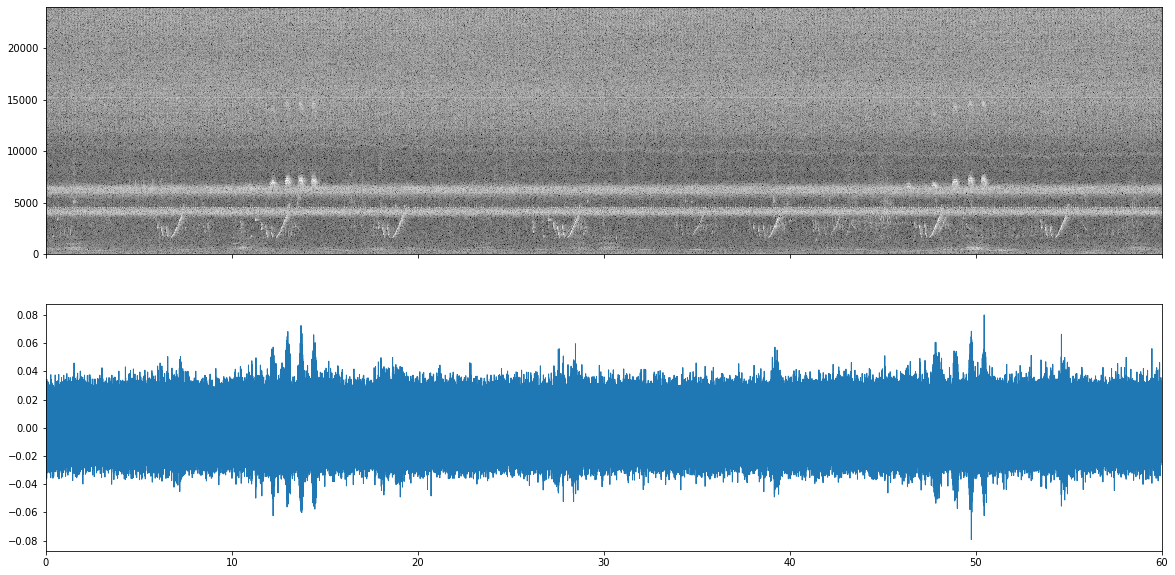

In [10]:
fig, ax = plt.subplots(2,1,figsize=(20,10),sharex=True)
recordings.audio[0].features.db_spectrogram().plot(ax=ax[0])
recordings.audio[0].plot(ax=ax[1])

Te method *insert_into* iterates, transform and insert datastore elements into a collection, producing an entry for the datastore to reference the origin of data. The following collection is held in memory (which is the default behaviour) so no database is needed for this example. Thanks to the addition of extra information about time reference, we can create a time aware collection with the class *TimedCollection* (the same can be achieved using the *collection* method with the parameter *col_type="timed"* as noted). See notebook about collections for a detailed explanation of distinct database backends and collection methods.

In [11]:
# Alternative:
# col = collection(col_type="timed")
col = TimedCollection()

In [12]:
col.db_config

{'provider': 'sqlite', 'config': {'filename': ':memory:', 'create_db': True}}

In [13]:
datastore_id, recording_inserts, annotation_inserts = pstorage.insert_into(col)
print("Datastore id: ", datastore_id)
print("Recording inserts: ", recording_inserts)
print("Annotation inserts: ", annotation_inserts)
print("Collection size: ", len(col))

  0%|          | 0/5 [00:00<?, ?it/s]

Datastore id:  1
Recording inserts:  5
Annotation inserts:  0
Collection size:  5


Thanks to unique constraints on the hash and path fields, duplicate insertion is almost impossible. After insertion, the collection can be queried in many ways, producing projections as dataframes, amongo other useful outputs. The output of the method *get_recording_dataframe* is almost the same as before but adds the following database specific fields:
* *datastore*: refers to the source datastore id inserted by *insert_into* method of the *Datastore* instance.
* *classtype*: is the specific database class for the recording. In this case, we provided time information so it corresponds to a *TimedRecording*
* *id*: the unique id assigned to the recording

Additional parameters that are different from the datastore corresponding method, such ass *offset*, *limit* and *query*, control the contents of the retrieved dataframe.

In [14]:
col.get_recording_dataframe(with_metadata=True, offset=1, limit=2)

,id,datastore,path,hash,timeexp,spectrum,metadata,classtype,time_raw,time_format,time_zone,time_utc,duration,filesize,length,nchannels,samplerate,sampwidth
0,2,1,./../src/yuntu/tests/test_data/20210804_063000...,167a8ea12eec7ef09230fd33993ae71e,1.0,audible,"{'Project': 'SiPeCaM', 'am_id': '243B1F055B1F8...",TimedRecording,06:30:00 04/08/2021 (UTC-0600),%H:%M:%S %d/%m/%Y (%Z%z),UTC,2021-08-04 06:30:00-06:00,60.003042,5760484,2880146,1,48000,16
1,3,1,./../src/yuntu/tests/test_data/20210804_061000...,226f2682f2bb732a74af602fb9dff90a,1.0,audible,"{'Project': 'SiPeCaM', 'am_id': '243B1F055B1F8...",TimedRecording,06:10:00 04/08/2021 (UTC-0600),%H:%M:%S %d/%m/%Y (%Z%z),UTC,2021-08-04 06:10:00-06:00,60.003042,5760484,2880146,1,48000,16


Using collections together with datastores one can first integrate data into a common structure that can hold high volumes of data and then produce fragments of information of any size as dataframes for sharded processing with pandas or dask.